# Project Luther - Weeks 01 and 02

## _Predicting U.S. box office receipts_, by Steven Bierer
(Jupyter Notebook 1 of 1)

### Scope of analysis:

The objective of this project was to create a predictive model, for data of our choice, based on linear regression. I chose domestic box office sales of feature films presented in theaters in the United States since 2000, using data obtained from the Internet Movie Database (IMDb.com). The features I used to form the predictions were both numerical (e.g. financial budget, year and week) and categorical (movie genre, primary language, etc).

The primary tools used include Python libraries for data manipulation (```pandas```, ```numpy```), linear regression (```statsmodels```, ```sklearn```), and graphical display (```matplotlib```, ```seaborn```). The [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/) Python module was used for obtaining content from the web. All data were obtained from [IMDb](http://imdb.com/).

#### -------- Section 1:  Obtain movie data by web scraping ----------------------------------------------

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from IMDbSuite import imdb_dataframe

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Get "raw" data from IMDb and store it as a .csv, manually specifying the year #
REMAKE = False  # no need to run this once files are set
YEAR = 2014
SAVE_PREFIX = 'data/df_imdb'; SAVE_SUFFIX = '.csv'

if REMAKE:
    df_year = imdb_dataframe(YEAR)
    df.to_csv(f'{SAVE_PREFIX}{YEAR}{SAVE_SUFFIX}')

In [7]:
# Load raw date from .csv files and merge into a single dataframe #
RELOAD = True  # load once and move on
YEARLIST = [i for i in range(2000,2018+1)]
LOAD_PREFIX = 'data/df_imdb'; LOAD_SUFFIX = '.csv'

if RELOAD:
    ntitles_raw = {}     # keep track of original # of movies for each year
    
    df_rawdata = pd.DataFrame()
    for year in YEARLIST:
        csvfile = f'{LOAD_PREFIX}{year}{LOAD_SUFFIX}'
        df = pd.read_csv(csvfile,index_col=0) # use column 0 = 'Code' as index
        df_rawdata = df_rawdata.append(df)
        
        ntitles_raw[year] = len(df)

df_rawdata.sort_values('Budget',ascending=False,inplace=True);
print('Number of titles by year --', ntitles_raw)
df_rawdata.head()

Number of titles by year -- {2000: 625, 2001: 668, 2002: 667, 2003: 558, 2004: 628, 2005: 657, 2006: 762, 2007: 750, 2008: 766, 2009: 799, 2010: 695, 2011: 730, 2012: 680, 2013: 703, 2014: 753, 2015: 671, 2016: 652, 2017: 592, 2018: 434}


,Title,Genre,MPAA,Country,Language,Rating_User,Rating_Count,Release_Date,Budget,Sales_Opening,Sales_Gross
Code,,,,,,,,,,,
tt4154756,Avengers: Infinity War,"('Action', 'Adventure', 'Fantasy', 'Sci-Fi')",PG-13,USA,ENGLISH,8.60,500408,2018-04-27,321.00,257.70,678.82
tt3778644,Solo: A Star Wars Story,"('Action', 'Adventure', 'Fantasy', 'Sci-Fi')",PG-13,USA,ENGLISH,7.00,155355,2018-05-25,300.00,84.42,213.77
tt0449088,Pirates of the Caribbean: At World's End,"('Action', 'Adventure', 'Fantasy')",PG-13,USA,ENGLISH,7.10,539188,2007-05-25,300.00,139.80,309.42
tt0974015,Justice League,"('Action', 'Adventure', 'Fantasy', 'Sci-Fi')",PG-13,UK,ENGLISH,6.60,287512,2017-11-17,300.00,93.84,229.02
tt0398286,Tangled,"('Animation', 'Adventure', 'Comedy', 'Family',...",NaN,USA,ENGLISH,7.80,348109,2010-11-24,260.00,48.77,200.82


## Filter and transform the data

In [8]:
# Create filters for data, to keep only those titles with required content #
mask_budget = ~df_rawdata['Budget'].isnull()
mask_salesg = ~df_rawdata['Sales_Gross'].isnull()
mask_saleso = ~df_rawdata['Sales_Opening'].isnull()
mask_urating = df_rawdata['Rating_Count'] > 100
mask_minsales = df_rawdata['Sales_Gross'] > 0.5
mask_english = df_rawdata['Language'] == 'ENGLISH'
mask_genre = ~df_rawdata['Genre'].isnull()

tempcol = df_rawdata['Budget']
tempcol.fillna(0,inplace=True)
mask_nobudget = tempcol == 0     # Low/High budget cutoff is $40 million
mask_lowbudget = (tempcol < 50) & (tempcol > 5)
mask_highbudget = (tempcol > 50)

In [9]:
# Week of year will allow comparisons between years and facilitate time series analysis #
df_working = df_rawdata.copy(deep=True)  # first, create copy so original data frame reamins unaltered

df_working['Release_DT'] = pd.to_datetime(df_working['Release_Date'], format='%Y-%m-%d')
df_working['Release_Week'] = df_working['Release_DT'].dt.week
df_working['Release_Year'] = df_working['Release_DT'].dt.year

# mask_year = df_working['Release_DT'] <= datetime.strptime(datetime.now(),'%Y-%m-%d')
mask_year = df_working['Release_DT'] <= datetime.now()
df_working = df_working[mask_year]  # some un-released movies snuck into the 2018 data!

print(f'Number of released movies in targeted years: {len(df_working)}')

Number of released movies in targeted years: 11781


In [10]:
# Create a binary for movies produced in English (regardless of country or origin) #
df_working['English'] = 0
df_working.loc[mask_english,'English'] = 1

In [11]:
# Create a scale for MPAA ratings from lowest (0) to highest (4) potential audience based on viewer age #
mpaa_list = ['UNRATED','NC-17','R','PG-13','PG','G']
age_list = [0, 0, 1, 2, 3, 4]

df_working['MPAA_level'] = df_working['MPAA']
df_working['MPAA_level'].replace(mpaa_list, age_list, inplace=True)

In [12]:
# Create a binary for family and/or animated movies #
df_working.loc[~mask_genre,'Genre'] = ('None')  # make sure there are no empty tuples

df_working['Family'] = [('Family' in x)|('Animated' in x) for x in df_working['Genre']]
df_working['Family'].replace([True,False], [1,0], inplace=True)

In [13]:
# Create a binary for action and/or adventure and/or thriller movies #
df_working['Action'] = [('Action' in x)|('Adventure' in x)|('Thriller' in x) for x in df_working['Genre']]
df_working['Action'].replace([True,False], [1,0], inplace=True)

In [14]:
# Create a binary for comedy movies #
df_working['Comedy'] = [('Comedy' in x) for x in df_working['Genre']]
df_working['Comedy'].replace([True,False], [1,0], inplace=True)

In [15]:
# Create a binary for horror movies #
df_working['Horror'] = [('Horror' in x) for x in df_working['Genre']]
df_working['Horror'].replace([True,False], [1,0], inplace=True)

In [16]:
# Remove pre-transformed columns #
df_working.drop(['MPAA','Country','Language','Release_Date'],axis=1,inplace=True)
df_working.tail(6)

,Title,Genre,Rating_User,Rating_Count,Budget,Sales_Opening,Sales_Gross,Release_DT,Release_Week,Release_Year,English,MPAA_level,Family,Action,Comedy,Horror
Code,,,,,,,,,,,,,,,,
tt8179218,Alex & Me,"('Family', 'Sport')",5.60,187,0.00,nan,nan,2018-06-12,24.00,"2,018.00",1,0,1,0,0,0
tt8288836,Red Forrest,"('Horror',)",8.20,1258,0.00,nan,nan,2018-06-18,25.00,"2,018.00",1,0,0,0,0,1
tt8359848,Climax,"('Drama', 'Horror', 'Musical', 'Mystery')",7.60,1813,0.00,nan,nan,2018-09-19,38.00,"2,018.00",0,NaN,0,0,0,1
tt8383596,Deok-gu,"('Drama',)",7.30,37,0.00,nan,nan,2018-04-05,14.00,"2,018.00",0,0,0,0,0,0
tt8577370,The House on Mansfield Street,"('Horror',)",3.60,101,0.00,nan,nan,2018-06-22,25.00,"2,018.00",1,0,0,0,0,1
tt8581198,Jane and Emma,"('Drama',)",nan,0,0.00,nan,nan,2018-10-12,41.00,"2,018.00",1,NaN,0,0,0,0


## Get a graphical overview of important trends ##

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import seaborn as sns

%config InlineBackend.figure_format = 'png'
%matplotlib inline 

In [18]:
# Define some useful cut-off values #
sales_over100 = (df_working['Sales_Opening'] > 100).sum()
budget_over50 = (df_working['Budget'] > 50).sum()
print(sales_over100, budget_over50)

55 880


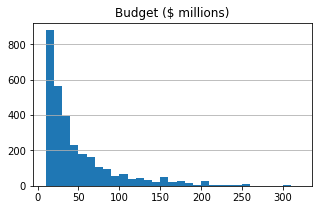

In [19]:
# Look at the budgets for all movies #
fig, ax_hist = plt.subplots(figsize=[5,3])

hbins = np.arange(10,330,10);
df_working.hist(column='Budget',ax=ax_hist,bins=hbins);

ax_hist.set_xticks(np.arange(0,340,50));
ax_hist.grid(axis='x');
ax_hist.set_title('Budget ($ millions)');

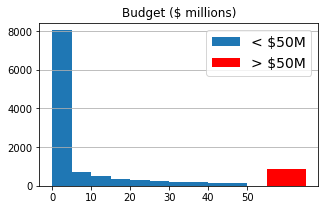

In [20]:
# Focus on the lower range of budgets #
fig, ax_hist = plt.subplots(figsize=[5,3])
hbins = np.arange(0,51,5);  # high budgets are plotted in red
df_working.hist(column='Budget',ax=ax_hist,bins=hbins);
plt.bar(55,budget_over50,align='edge',width=10,color='r')

ax_hist.set_xticks(np.arange(0,60,10));
ax_hist.grid(axis='x');
ax_hist.set_title('Budget ($ millions)');
plt.legend(['< $50M','> $50M'],fontsize=14);

/Users/neuromac/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


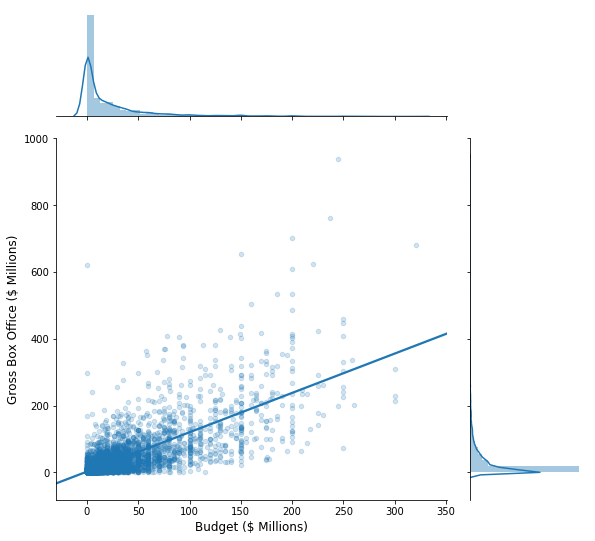

In [21]:
# Create a scatter plot of box office versu budget for all movies #
grid = sns.jointplot("Budget", "Sales_Gross", ratio=3, kind="regplot", ci=None,
                     scatter_kws={'alpha':0.2,'s':20}, data=df_working);
grid.fig.set_figwidth(20); grid.fig.set_figheight(12)
grid.set_axis_labels('Budget ($ Millions)', 'Gross Box Office ($ Millions)', fontsize=12)
grid.fig.subplots_adjust(left=.6,bottom=.4)

grid.savefig('supporting_files/SalesVsBudget_Joint.png')

In [65]:
# Save the dataframe for subsequent analysis #
import pickle
with open('data/df_working_20181012b.pkl', 'wb') as picklefile:
    pickle.dump(df_working, picklefile)

## Separate data based on size of budget

In [52]:
# Read in data if necessary #
import pickle
with open('data/df_working_20181012b.pkl', 'rb') as picklefile: 
    df_working = pickle.load(picklefile)

In [53]:
# Define subsets of movies based on budget amount #
df_low = df_working.loc[mask_lowbudget & mask_urating & mask_minsales]
df_high = df_working.loc[mask_highbudget & mask_urating & mask_minsales]
df_all = df_working.loc[~mask_nobudget & mask_urating & mask_minsales]

print('Number of movies in low/high/all budget sets:', len(df_low), len(df_high), len(df_all))

Number of movies in low/high/all budget sets: 1825 868 3129


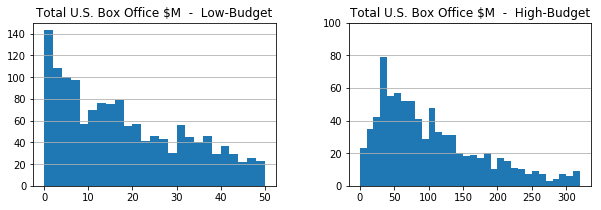

In [54]:
# Look at the distribution of total box office for low- and high-budget fimls #
fig, ax_hist = plt.subplots(1,2,figsize=[10,3])
hbins = np.arange(0,52,2);
df_low.hist(column='Sales_Gross',ax=ax_hist[0],bins=hbins,grid=True);
hbins = np.arange(0,330,10);
df_high.hist(column='Sales_Gross',ax=ax_hist[1],bins=hbins,grid=True);

ax_hist[1].set_ylim(0,100)
ax_hist[0].set_title('Total U.S. Box Office $M  -  Low-Budget');
ax_hist[1].set_title('Total U.S. Box Office $M  -  High-Budget');
ax_hist[0].grid(axis='x'); ax_hist[1].grid(axis='x');

In [55]:
df_all.corr()  # indep. variables not correlated, so that's good

,Rating_User,Rating_Count,Budget,Sales_Opening,Sales_Gross,Release_Week,Release_Year,English,USA,MPAA_level,Family,Comedy,Action,Horror
Rating_User,1.00,0.50,0.13,0.14,0.25,0.06,0.08,-0.16,-0.16,-0.01,-0.10,-0.20,-0.02,-0.20
Rating_Count,0.50,1.00,0.49,0.55,0.65,0.07,0.03,0.04,0.04,-0.00,-0.06,-0.16,0.22,-0.06
Budget,0.13,0.49,1.00,0.72,0.70,0.05,0.07,0.10,0.10,0.02,0.22,-0.07,0.37,-0.14
Sales_Opening,0.14,0.55,0.72,1.00,0.92,-0.01,0.12,0.09,0.09,0.04,0.14,-0.03,0.27,-0.03
Sales_Gross,0.25,0.65,0.70,0.92,1.00,0.05,0.09,0.09,0.09,0.05,0.19,0.00,0.23,-0.08
Release_Week,0.06,0.07,0.05,-0.01,0.05,1.00,-0.04,0.03,0.03,0.00,0.04,-0.01,-0.03,-0.02
Release_Year,0.08,0.03,0.07,0.12,0.09,-0.04,1.00,-0.01,-0.01,0.47,-0.01,-0.08,0.07,0.04
English,-0.16,0.04,0.10,0.09,0.09,0.03,-0.01,1.00,1.00,0.04,0.01,0.08,-0.01,0.03
USA,-0.16,0.04,0.10,0.09,0.09,0.03,-0.01,1.00,1.00,0.04,0.01,0.08,-0.01,0.03
MPAA_level,-0.01,-0.00,0.02,0.04,0.05,0.00,0.47,0.04,0.04,1.00,0.19,0.07,-0.01,-0.03


## Create time-series features

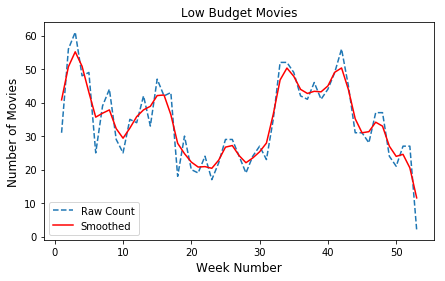

In [56]:
# Create a "seasonality metric" for low-budget movies #
df_wktrend = df_low.groupby(['Release_Week']).count()['Sales_Gross']
df_wkroll = df_wktrend.rolling(5, win_type='hamming', center=True,
        min_periods=1).mean()                       # sum over years and smooth

fig, ax_trend = plt.subplots(figsize=[7,4])

plt.plot(df_wktrend.index,df_wktrend.values,'--');  # plot the results
plt.plot(df_wkroll.index,df_wkroll.values,'-',color='r');
plt.xlabel('Week Number',fontsize=12);
plt.ylabel('Number of Movies',fontsize=12)
plt.legend(['Raw Count','Smoothed'])
plt.title('Low Budget Movies')
                                                    # standardize the feature
df_season_low = (df_wkroll-df_wkroll.mean())/df_wkroll.std()
df_season_low.rename('Season_Low', inplace=True);

# plt.savefig('supporting_files/SeasonLow.png')

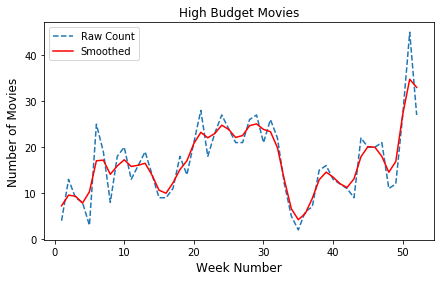

In [57]:
# Same as above but for high-budget movies #
df_wktrend = df_high.groupby(['Release_Week']).count()['Sales_Gross']
df_wkroll = df_wktrend.rolling(5, win_type='hamming', center=True,
        min_periods=1).mean()

fig, ax_trend = plt.subplots(figsize=[7,4])

plt.plot(df_wktrend.index,df_wktrend.values,'--');
plt.plot(df_wkroll.index,df_wkroll.values,'-',color='r');
plt.xlabel('Week Number',fontsize=12);
plt.ylabel('Number of Movies',fontsize=12)
plt.legend(['Raw Count','Smoothed'])
plt.title('High Budget Movies')

df_season_high = (df_wkroll-df_wkroll.mean())/df_wkroll.std()
df_season_high.rename('Season_High', inplace=True);

# plt.savefig('supporting_files/SeasonHigh.png')

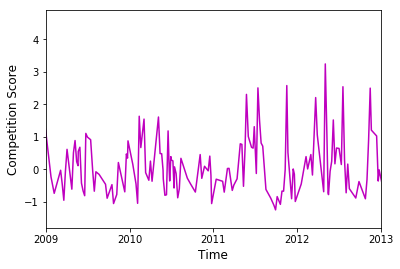

In [58]:
# Create a "competition score" based on high-budget sales of other movies #
# Note: the moving average filter applied below is NOT centered, such that
# it imposes a lag on the filter output; specifically, the week aligned to
# the leading edge is two weeks past the week of the movie opening, allowing
# past movies to impact the score.
df_dttrend = df_high.groupby(['Release_DT']).sum()['Sales_Opening']
df_threat = df_dttrend.rolling(3, win_type='hamming', center=False,
        min_periods=1).mean()   # lower weight on impact from previous weeks
df_threat = df_dttrend + 0.5*df_threat 
df_threat.rename('Threat_High', inplace=True);
                                # standardize the score
df_threat_high = (df_threat-df_threat.mean())/df_threat.std()

plt.plot(df_threat_high.index,df_threat_high,'-',color='m');
plt.xlabel('Time',fontsize=12);
plt.ylabel('Competition Score',fontsize=12);
plt.xlim('2009-01-01', '2012-12-31');
plt.xticks(['2009','2010','2011','2012','2013']);

plt.savefig('supporting_files/Competition_Score.png')

In [59]:
# Merge the time-series scores into the working data frame #
df_temp = pd.DataFrame(df_threat_high)
df_test = df_working.merge(df_temp,how='left',on='Release_DT',left_index=True).set_index(df_working.index)
df_temp = pd.DataFrame(df_season_low)
df_test = df_test.merge(df_temp,how='left',on='Release_Week',left_index=True).set_index(df_test.index)
df_temp = pd.DataFrame(df_season_high)
df_final = df_test.merge(df_temp,how='left',on='Release_Week',left_index=True).set_index(df_test.index)

df_final.head()

# Store the new dataframe #
with open('data/df_final_20181012.pkl', 'wb') as picklefile:
    pickle.dump(df_final, picklefile)

In [60]:
# Redefine the low-budget, etc, dataframes #
# Note that "all" stil requires budget to exist and be non-zero #
df_low = df_final.loc[mask_lowbudget & mask_urating & mask_minsales]
df_high = df_final.loc[mask_highbudget & mask_urating & mask_minsales]
df_all = df_final.loc[~mask_nobudget & mask_urating & mask_minsales]

In [61]:
df_low = df_low.fillna({'Threat_High': df_threat_high.min(), 'Season_High': df_season_high.min(),
            'Season_Low': df_season_low.min()})
df_high = df_high.fillna({'Threat_High': df_threat_high.min(), 'Season_High': df_season_high.min(),
            'Season_Low': df_season_low.min()})
df_all = df_all.fillna({'Threat_High': df_threat_high.min(), 'Season_High': df_season_high.min(),
            'Season_Low': df_season_low.min()})

In [62]:
# The desired features for modeling seem not very correlated #
df_all.corr()

,Rating_User,Rating_Count,Budget,Sales_Opening,Sales_Gross,Release_Week,Release_Year,English,USA,MPAA_level,Family,Comedy,Action,Horror,Threat_High,Season_Low,Season_High
Rating_User,1.00,0.50,0.13,0.14,0.25,0.06,0.08,-0.16,-0.16,-0.01,-0.10,-0.20,-0.02,-0.20,0.12,-0.06,0.09
Rating_Count,0.50,1.00,0.49,0.55,0.65,0.07,0.03,0.04,0.04,-0.00,-0.06,-0.16,0.22,-0.06,0.31,-0.19,0.20
Budget,0.13,0.49,1.00,0.72,0.70,0.05,0.07,0.10,0.10,0.02,0.22,-0.07,0.37,-0.14,0.48,-0.30,0.29
Sales_Opening,0.14,0.55,0.72,1.00,0.92,-0.01,0.12,0.09,0.09,0.04,0.14,-0.03,0.27,-0.03,0.51,-0.24,0.20
Sales_Gross,0.25,0.65,0.70,0.92,1.00,0.05,0.09,0.09,0.09,0.05,0.19,0.00,0.23,-0.08,0.50,-0.28,0.28
Release_Week,0.06,0.07,0.05,-0.01,0.05,1.00,-0.04,0.03,0.03,0.00,0.04,-0.01,-0.03,-0.02,0.08,-0.17,0.33
Release_Year,0.08,0.03,0.07,0.12,0.09,-0.04,1.00,-0.01,-0.01,0.47,-0.01,-0.08,0.07,0.04,0.20,-0.00,-0.00
English,-0.16,0.04,0.10,0.09,0.09,0.03,-0.01,1.00,1.00,0.04,0.01,0.08,-0.01,0.03,0.04,-0.03,0.04
USA,-0.16,0.04,0.10,0.09,0.09,0.03,-0.01,1.00,1.00,0.04,0.01,0.08,-0.01,0.03,0.04,-0.03,0.04
MPAA_level,-0.01,-0.00,0.02,0.04,0.05,0.00,0.47,0.04,0.04,1.00,0.19,0.07,-0.01,-0.03,0.10,-0.03,0.04


## Preliminary regression analysis

In [63]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import scipy.stats as stats

0.2511664426978309


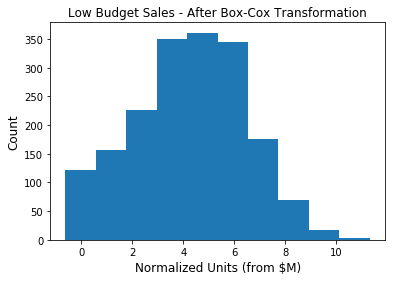

In [64]:
# As in W03D03 lecture, force data to be more normal #
# Gross - Low: .251, High: .210, All: .172
# Budget - Low: .436, High: -.771, All: .225
lamb = stats.boxcox_normmax(df_low['Sales_Gross'], brack=(-1.9, 1.9))
ybox = (np.power(df_low['Sales_Gross'],.210)-1)/.210
plt.hist(ybox);
plt.xlabel('Normalized Units (from $M)', fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.title('Low Budget Sales - After Box-Cox Transformation')

print(lamb)
# plt.savefig('supporting_files/Normalized_Sales_Low.png')

In [66]:
# Perform a first-order linear regression on choice of dataframe: low, high or all #
# Most variables kept. 'Country' not included as it was highly correlated with 'English'.
# Gross (y) - Low: .251, High: .210, All: .172
# Budget (x) - Low: .436, High: -.771, All: .225
df_try = df_low
var_input = 'Sales_Gross ~ Budget + Season_Low + Season_High + Release_Year + \
    Action + Horror + Comedy + Family + MPAA_level + English'
p_y = .251  # use values recorded in previous cell
p_x = .436

y, X = patsy.dmatrices(var_input, data=df_try, return_type="dataframe")
y_t = (np.power(y,p_y)-1)/p_y  # transform some of the variables
X['Budget'] = (np.power(X['Budget'],p_x)-1)/p_x
X['Release_Year'] = X['Release_Year'] - X['Release_Year'].mean()

model = sm.OLS(y_t, X)
fit = model.fit()

ypred_t = fit.predict(X)                     # prediction in transformed units
ypred = np.power(ypred_t * p_y + 1, 1./p_y)  # prediction in reverse-transformed units
y = y['Sales_Gross']

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Sales_Gross   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     51.39
Date:                Tue, 16 Oct 2018   Prob (F-statistic):           3.89e-91
Time:                        00:22:59   Log-Likelihood:                -4029.1
No. Observations:                1825   AIC:                             8080.
Df Residuals:                    1814   BIC:                             8141.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.3412      0.358     -0.952      0.341      -1.044       0.362
Budget           0.4898      0.027     18.389      0.000       0.438       0.542
Season_Low       0.2915      0.102      2.864      0.004       0.092       0.491
Season_High      0.4024      0.101      3.967      0.000       0.203       0.601
Release_Year     0.0308      0.012      2.650      0.008       0.008       0.054
Action          -0.0779      0.116     -0.671      0.503      -0.306       0.150
Horror           1.0855      0.167      6.509      0.000       0.758       1.413
Comedy           0.5827      0.117      4.976      0.000       0.353       0.812
Family           0.6770      0.180      3.757      0.000       0.324       1.030
MPAA_level      -0.0830      0.074     -1.121      0.262      -0.228       0.062
English          1.6358      0.303      5.392      0.000       1.041       2.231
==============================================================================
Omnibus:                        3.156   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.206   Jarque-Bera (JB):                3.164
Skew:                           0.081   Prob(JB):                        0.206
Kurtosis:                       2.877   Cond. No.                         61.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

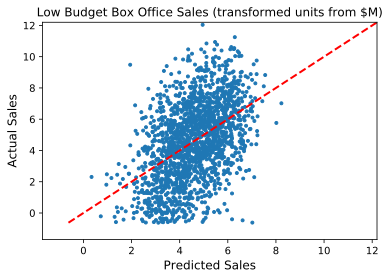

In [206]:
plt.plot(ypred_t,y_t,'.');
plt.title('Low Budget Box Office Sales (transformed units from $M)');
xx = np.arange(min(y_t.values),max(y_t.values),.1)
plt.plot(xx,xx,'--',linewidth=2,color='r')
# plt.legend(['Low Budget (transformed units)']);
plt.xlim(-1.7,12.2); plt.ylim(-1.7,12.2)
plt.xlabel('Predicted Sales',fontsize=12);
plt.ylabel('Actual Sales',fontsize=12)

# plt.savefig('supporting_files/Regression_Initial_Low.png')

## Cross-validation and model-order analysis

In [67]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import make_pipeline

/Users/neuromac/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [68]:
# Create models with polynomial features, looping through degrees #
# Gross (y) - Low: .251, High: .210, All: .172
# Budget (x) - Low: .436, High: -.771, All: .225
df_try = df_low   # keep all the variables this time around
var_input = 'Sales_Gross ~ Budget + Season_Low + Season_High + Release_Year + \
    Action + Horror + Comedy + Family + MPAA_level + English'
dvar_input = ['Action', 'Horror', 'Comedy', 'Family', 'English']
p_y = .251
p_x = .436

y, X = patsy.dmatrices(var_input, data=df_try, return_type="dataframe")
y_t = (np.power(y,p_y)-1)/p_y
X['Budget'] = (np.power(X['Budget'],p_x)-1)/p_x
X['Release_Year'] = X['Release_Year'] - X['Release_Year'].mean()
X.drop(columns='Intercept',inplace=True)

lr = LinearRegression()

res_cv = {}
res_train = {}
for deg in range(6):
    poly = PolynomialFeatures(degree=deg, include_bias=True)
    Xpoly = pd.DataFrame(poly.fit_transform(X), index=X.index)

    cnames = poly.get_feature_names(X.columns)
    Xpoly.columns = cnames
    del_list = []  # drop polynomials 2+ for all categorical variables
    for ftr in dvar_input:  # (as 1's and 0s square to themselves)
        for pwr in range(2,deg+1):
            del_list.append(ftr+'^'+str(pwr))
    Xpoly.drop(columns=del_list, inplace=True) 
    
    scores = cross_val_score(lr, Xpoly, y_t, cv=4, scoring='neg_mean_squared_error')
    res_cv[deg] = np.mean(-scores)  # automatically separates into 4 train/test
    
    lr.fit(Xpoly, y_t)
    ypred_t = lr.predict(Xpoly)     # training set MSE must be manually calculated
    res_train[deg] = np.sum((ypred_t-y_t.values)**2)/len(y)

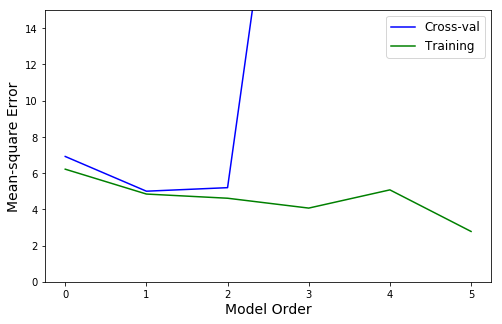

In [70]:
# Plot the change in error as a function of model order #
# For low-budget movies, 2nd-order should be OK to try with regularization.
xx = list(res_cv.keys())
yy_cv = list(res_cv.values())
yy_train = list(res_train.values())

plt.figure(figsize=[8,5])
plt.plot(xx,yy_cv,'b')
plt.plot(xx,yy_train,'g')
plt.xlabel('Model Order',fontsize=14)
plt.ylabel('Mean-square Error',fontsize=14)
plt.legend(['Cross-val','Training'],fontsize=12)

plt.ylim(0,15);
# plt.savefig('supporting_files/CV_ModelOrder_Low.png')

## Lasso Regularization##

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [72]:
# Set up data and split into training and testing sets, as 70% and 30% of the data points #
# Gross (y) - Low: .251, High: .210, All: .172
# Budget (x) - Low: .436, High: -.771, All: .225
df_try = df_low
var_input = 'Sales_Gross ~ Budget + Season_Low + Season_High + Release_Year + \
    Action + Horror + Comedy + Family + MPAA_level + English'
p_y = .251
p_x = .436

y, X = patsy.dmatrices(var_input, data=df_try, return_type="dataframe")
y_t = (np.power(y,p_y)-1)/p_y
X['Budget'] = (np.power(X['Budget'],p_x)-1)/p_x
X['Release_Year'] = X['Release_Year'] - X['Release_Year'].mean()
X.drop(columns='Intercept', inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y_t, test_size=0.3,random_state=42)

In [86]:
# Run Lasso-regularized regression over a wide range of lamda/alpha values #
deg = 2
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 3]

poly = PolynomialFeatures(degree=deg, include_bias=True)
Xpoly_train = pd.DataFrame(poly.fit_transform(X_train), index=X_train.index)
Xpoly_test = pd.DataFrame(poly.fit_transform(X_test), index=X_test.index)
cnames = poly.get_feature_names(X_train.columns)
Xpoly_train.columns = cnames; Xpoly_test.columns = cnames
del_list = []           # must drop polynomials 2+ for all categorical variables
for ftr in dvar_input:  # (as 1's and 0s square, cube, etc to themselves)
    for pwr in range(2,deg+1):
        del_list.append(ftr+'^'+str(pwr))
Xpoly_train.drop(columns=del_list, inplace=True)
Xpoly_test.drop(columns=del_list, inplace=True)

mse_tr_Lasso = []
mse_te_Lasso = []
r2_tr_Lasso = []
r2_te_Lasso = []
for alpha in alphas:
    lrl = Lasso(alpha=alpha)   # run Lasso at each alpha value, store results
    lrl.fit(Xpoly_train, y_train);
    
    cvtemp = cross_val_score(lrl, Xpoly_train, y_train, cv=4, scoring='neg_mean_squared_error')
#     mse_tr_Lasso.append(mean_squared_error(y_train, lrl.predict(Xpoly_train)))
    mse_tr_Lasso.append(np.mean(-cvtemp))
    mse_te_Lasso.append(mean_squared_error(y_test, lrl.predict(Xpoly_test)))
    
    cvtemp = cross_val_score(lrl, Xpoly_train, y_train, cv=4, scoring='r2')
    r2_tr_Lasso.append(np.mean(cvtemp))
#     r2_tr_Lasso.append(lrl.score(Xpoly_train,y_train))
    r2_te_Lasso.append(lrl.score(Xpoly_test,y_test))

/Users/neuromac/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/neuromac/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/neuromac/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/neuromac/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

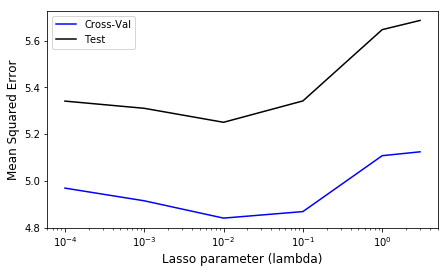

In [107]:
# Plot the MSE vs lambda #
plt.figure(figsize=[7,4])
plt.semilogx(alphas,mse_tr_Lasso,'b');
plt.semilogx(alphas,mse_te_Lasso,'k');
plt.xlabel('Lasso parameter (lambda)',fontsize=12)
plt.ylabel('Mean Squared Error',fontsize=12)
plt.legend(['Cross-Val','Test']);

plt.savefig('supporting_files/LassoMSE_Low.png')

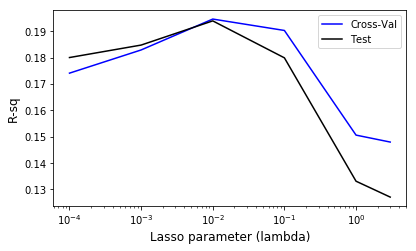

In [108]:
# Plot R-square vs lambda #
fig, ax_trend = plt.subplots(figsize=[7,4])

plt.semilogx(alphas,r2_tr_Lasso,'b');
plt.semilogx(alphas,r2_te_Lasso,'k');
plt.xlabel('Lasso parameter (lambda)',fontsize=12)
plt.ylabel('R-sq',fontsize=12)
plt.legend(['Cross-Val','Test']);

fig.subplots_adjust(bottom=.2,left=.2)
plt.savefig('supporting_files/LassoR2_Low.png')

In [93]:
# Look at the coefficients that the Lasso regularization left #
alpha_best = 1e-2  # best from graph above
lrl = Lasso(alpha=alpha_best)
lrl.fit(Xpoly_train, y_train);
coef = lrl.coef_.ravel()

for i,cc in enumerate(coef):
    if abs(cc) > 1e-2:
        print(f'{cnames[i]} : {cc}')

Budget : 0.5429644175180695
Season_Low : 0.23110357627006045
Release_Year : 0.08930719570884059
Horror : 1.5211504316572402
Budget^2 : -0.016467296818819647
Budget Season_High : 0.034840267332019954
Budget Action : -0.02534230874148138
Budget Horror : -0.19143897367909915
Budget Comedy : 0.01609674648345297
Budget English : 0.21974957909794665
Season_Low Season_High : 0.012098968750965819
Season_Low Horror : 0.19900168517552375
Season_Low Comedy : -0.08228678602215675
Season_Low MPAA_level : 0.08477544936885517
Season_High^2 : 0.021890183159715134
Season_High Release_Year : -0.010603286170931816
Season_High MPAA_level : 0.10373732210491078
Release_Year Action : 0.024356236246688385
Release_Year Comedy : 0.030338615544775453
Release_Year Family : -0.027753167258778452
Release_Year MPAA_level : -0.030913789052996746
Action English : -0.4113371320134739
Horror Comedy : 0.2813214600038433
Comedy^2 : 0.44800248663570147
Comedy MPAA_level : 0.606925785933801
Comedy English : -0.0565778941801

In [109]:
# Calculate the R-square value for the transformed prediction #
ypred_t = lrl.predict(Xpoly_test)
ypred_t = np.array(ypred_t)[:,np.newaxis]

r2_t = 1 - (np.sum((ypred_t-y_test.values)**2) / np.sum((y_test.values-y_test.mean()[0])**2))
print(f'R-square: {r2_t:.3f} (in transformed units ^2)')

R-square: 0.194 (in transformed units ^2)


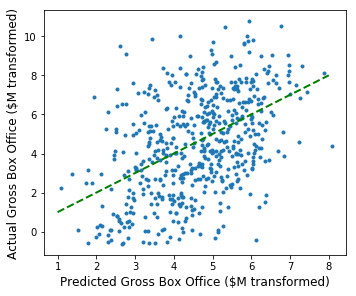

In [111]:
# Scatter plot of actual vs predicted values #
fig, ax_scttr = plt.subplots(figsize=[6,5])

plt.plot(ypred_t,y_test,'.');
plt.xlabel('Predicted Gross Box Office ($M transformed)', fontsize=12);
plt.ylabel('Actual Gross Box Office ($M transformed)', fontsize=12);

xx = np.arange(1,8.1,.1)
plt.plot(xx,xx,'--',color='g',linewidth=2)
# ax_scttr.set_xlim([-1.5,11.5])
# ax_scttr.set_ylim([-1.5,11.5])

fig.subplots_adjust(bottom=.2,left=.2)
# plt.savefig('supporting_files/ActualVPredicted_Low.png')

In [113]:
# Inspect the normality of the error residuals #
resid = y_test['Sales_Gross'] - ypred_t

#stats.probplot(data['resid'], dist="norm", plot=plt)
# plt.title("Normal Q-Q plot")
# plt.show()

In [122]:
resid = y_test['Sales_Gross'][:,np.newaxis] - ypred_t

In [125]:
resid.shape

(548, 1)